# Reinforcement Learning

Установим и импортируем необходимые библиотеки, а также вспомогательные функции для визуализации игры агента.

In [6]:
!pip install --user gym pandas torch matplotlib pyvirtualdisplay > /dev/null 2>&1
!apt-get install --user -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1

In [10]:
!pip install --user xvfbwrapper

  Stored in directory: /home/igor/.cache/pip/wheels/10/f2/61/cacfaf84b352c223761ea8d19616e3b5ac5c27364da72863f0
Successfully built xvfbwrapper


In [286]:
from IPython.display import clear_output, HTML
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
%matplotlib inline

In [2]:
import numpy as np
import glob
import time
import io
import base64
import gym
from gym.wrappers import Monitor
import torch
import collections
import pandas as pd
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical, Normal

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1009'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1009'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #позволяет перенести тензор на GPU, если он доступен в системе

## OpenAI Gym

[OpenAI Gym](https://gym.openai.com) это набор сред для разработки и сравнения алгоритмов обучения с подкреплением.

OpenAI Gym предоставляет простой и универсальный API ко многим средам с разными свойствами, как простым так и сложным:
* Классические задачи управления и игрушечные примеры, которые можно найти в учебниках и на которых демонстрируется работа алгоритмов обучения с подкреплением (одна из этих сред используется в этом задании)
* Игры Atari (оказали огромное влияние на достижения в обучении с подкреплением в последние годы)
* 2D и 3D среды для контроля роботов в симуляции (используют проприетарный движок [Mojuco](http://www.mujoco.org))

Создадим среду и выведем ее описание.

In [4]:
env = gym.make('MountainCarContinuous-v0')
print(env)

<TimeLimit<Continuous_MountainCarEnv<MountainCarContinuous-v0>>>


Из этого описания мы можем узнать, как устроены пространства состояний и действий в этой среды, какие награды получаются на каждом шаге, а также, что нам необходимо сделать, чтобы научиться "решать" эту среду, а именно достич средней награды больше 195.0 или больше за 100 последовательных запусков агента в этой среде. Именно такого агента мы и попробуем создать и обучить.

Но для начала напишем вспомогательную функцию, которая будет принимать на вход среду, агента и число эпизодов, и возвращать среднюю награду за 100 эпизодов. С помощью этой функции мы сможем протестировать, насколько хорошо обучился наш агент, а также визуализировать его поведение в среде.

In [306]:
def test_agent(env, DIST = Categorical, agent=None, n_episodes=100, render = False):
    """Runs agent for n_episodes in environment and calclates mean reward.
    
    Args:
        env: The environment for agent to play in
        agent: The agent to play with. Defaults to None - 
            in this case random agent is used.
        n_episodes: Number of episodes to play. Defaults to 100.

    Returns:
        Mean reward for 100 episodes.
    """
    total_reward = []
    velocities = []
    states = []
    sigma_array = []
    mu_array = []
    for episode in range(n_episodes):
        episode_reward = 0
        observation = env.reset()
        t = 0
        while True:
            if render:
                env.render()
            if agent:
                with torch.no_grad():
                    probs = agent(torch.FloatTensor(observation).to(device))
                    dist = DIST(*probs)
                    action = dist.sample().detach()
                    states.append(observation[0].item())
                    velocities.append(observation[1].item())
                    mu_array.append(probs[0])
                    sigma_array.append(probs[1])
            else:
                action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            episode_reward += reward
            t += 1
            if done:
                print("Episode {} finished after {} timesteps".format(episode+1, t+1))
                break
        total_reward.append(episode_reward)
    env.close()
    fig = plt.figure(figsize=[120, 60])
    ax_sigma =  fig.add_subplot(121, projection='3d')
    ax_mu =  fig.add_subplot(122, projection='3d')
    ax_sigma.set(title = 'Sigma'); ax_sigma.grid()
    ax_mu.set(title = 'Mu'); ax_mu.grid()
    ax_mu.plot(states, velocities, mu_array)
    ax_sigma.plot(states, velocities, sigma_array)
    plt.show()
    return np.mean(total_reward)

Протестируем и визуализируем случайного агента (параметр ```agent=False```).

In [11]:
test_agent(env, DIST = Normal, agent=False, n_episodes=100)

Episode 1 finished after 1000 timesteps
Episode 2 finished after 1000 timesteps
Episode 3 finished after 1000 timesteps
Episode 4 finished after 1000 timesteps
Episode 5 finished after 1000 timesteps
Episode 6 finished after 1000 timesteps
Episode 7 finished after 1000 timesteps
Episode 8 finished after 1000 timesteps
Episode 9 finished after 1000 timesteps
Episode 10 finished after 1000 timesteps
Episode 11 finished after 1000 timesteps
Episode 12 finished after 1000 timesteps
Episode 13 finished after 1000 timesteps
Episode 14 finished after 1000 timesteps
Episode 15 finished after 1000 timesteps
Episode 16 finished after 1000 timesteps
Episode 17 finished after 1000 timesteps
Episode 18 finished after 1000 timesteps
Episode 19 finished after 1000 timesteps
Episode 20 finished after 1000 timesteps
Episode 21 finished after 1000 timesteps
Episode 22 finished after 1000 timesteps
Episode 23 finished after 1000 timesteps
Episode 24 finished after 1000 timesteps
Episode 25 finished after

-33.21183185789235

Как видно, наш случайный агент выступает не очень хорошо и в среднем может удержать шест всего около 20 шагов.

Напишем функцию для визуализации агента и посмотрим на случайного агента.

In [9]:
def agent_viz(env="CartPole-v0", agent=None):
    """Visualizes agent play in the given environment.
    
    Args:
        env: The environment for agent to play in. Defaults to CartPole-v0.
        agent: The agent to play with. Defaults to None - 
            in this case random agent is used.

    Returns:
        Nothing is returned. Visualization is created and can be showed
            with show_video() function.
    """
    env = wrap_env(gym.make(env))
    observation = env.reset()
    while True:
        env.render() 
        if agent:
            with torch.no_grad():
                probs = agent(torch.FloatTensor(observation).to(device))
                dist = Categorical(probs)
                action = dist.sample().item()
        else:
            action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            break
            
    env.close()

In [10]:
agent_viz('MountainCarContinuous-v0')
show_video()

Попробуем применить обучение с подкреплением и алгоритм REINFORCE для того, чтобы в среднем за 100 эпиздов мы держали шест не менее 195 шагов.

## REINFORCE

Вспомним, что из себя представляет алгоритм REINFORCE (Sutton & Barto) <img src="//i.imgur.com/bnASTrY.png" width="700">

1. Инициализуем политику (в качестве политики мы будем использовать глубокую нейронную сеть).
2. "Играем" в среде эпизод, используя нашу политику, или несколько (мы будем использовать последний вариант) и собираем данные о состояниях, действиях и полученных наградах. 
3. Для каждого состояния в собранных эпизодах вычисляем сумму дисконтированных наград, полученных из этого состояния, а также логорифм правдоподобия предпринятого действия в этом состоянии для нашей политики.
4. Обновляем параметры нашей политики по формуле на схеме.

### Политика

Наша политика должна принимать на вход состояние среды, а на выходе выдавать распределение по действиям, которые мы можем осуществлять в среде.

**Задание:** Создать класс нейронной сети со следующей архитектурой ```Linear -> ReLU -> Linear -> Softmax```. Параметрами инициализации должны служить размерности пространства состояний, пространства действий и размер скрытого слоя.

In [6]:
class Policy(nn.Module):
    """Policy to be used by agent.

    Attributes:
        state_size: Dimention of the state space of the environment.
        act_size: Dimention of the action space of the environment.
        hidden_size: Dimention of the hidden state of the agent's policy.
    """
    
    # TO DO
    def __init__(self, state_size, act_size, hidden_size):
        super(Policy, self).__init__()
        self.state_space = state_size
        self.action_space = act_size
        self.hidden = hidden_size
        
        self.base = nn.Sequential(
            nn.Linear(self.state_space, self.hidden),
            nn.ReLU(),
        )
        self.mu = nn.Sequential(
            nn.Linear(self.hidden, self.action_space),
            nn.Tanh()
        )
        self.var = nn.Sequential(
            nn.Linear(self.hidden, self.action_space),
            nn.Softplus()
        )
        
    def forward(self, x):    
        base_out = self.base(x)
        return self.mu(base_out), self.var(base_out)

### Оценка правдоподобия и расчет суммы дисконтированных наград

**Задание:** Напишем вспомогательная функцию, которая принимает на вход политику, батч траекторий и фактор дисконтирования, и должна вернуть следующие величины: 
* правдоподобие действия на каждом шаге на траектории посчитанные для всего батча;
* дисконтированные суммы наград (reward-to-go) из каждого состояния среды на траектории посчитанные для всего батча;

**Hint**: Представим батч траекторий как ```list```, в котром также хранится ```list``` для каждой траектории, в котором каждый шаг хранится, как ```namedtuple```:
```transition = collections.namedtuple("transition", ["state", "action", "reward"])```

In [197]:
def process_traj_batch(model, batch, discount, REWARDS_SHAPING = 0, division = True):
    """Computes log probabilities for each action 
        and rewards-to-go for each state in the batch of trajectories.
    
    Args:
        policy: Policy of the agent.
        batch (list of list of collections.namedtuple): Batch of trajectories.
        discount (float): Discount factor for rewards-to-go calculation.

    Returns:
        log_probs (list of torch.FloatTensor): List of log probabilities for
            each action in the batch of trajectories.
        returns (list of rewards-to-go): List of rewards-to-go for 
            each state in the batch of trajectories.
    """
    
    # TO DO
    num_episodes = len(batch)
    transition = collections.namedtuple("transition", ["state", "action", "reward"])
    log_probs = torch.FloatTensor()
    returns = []
    for traj in batch:
        returns.append([])
        for step in traj:
            #print(step.state)
            mu, sigma = model(step.state)
            dist = Normal(mu, sigma)
            #print(log_probs)
            if len(log_probs) != 0:
                log_probs = torch.cat([log_probs, dist.log_prob(step.action).view(1)])
            else:
                log_probs = dist.log_prob(step.action).view(1)
            returns[-1].append(step.reward)
        #print(returns, traj)
        for i in range(1, len(traj)):
            returns[-1][0] += traj[i].reward*(discount**(i)) 
        for i in range(1, len(traj)):
            returns[-1][i] = (returns[-1][i-1] - traj[i-1].reward)/discount
        if REWARDS_SHAPING != 0:
            for i in range(1, len(traj)):
                returns[-1][i] = returns[-1][i] if returns[-1][i] > 0 else 0 + \
                (abs(traj[i].state[0]) + 10*abs(traj[i].state[1]))* REWARDS_SHAPING
    if division:
        returns = [x[i]/(sum([discount**(i) for i in range(len(x) - i)])) for x in returns for i in range(len(x))]
    else:
        returns = [y for x in returns for y in x]
    #print(log_probs, returns)
    return log_probs, returns

Ваша реализация функции должна проходить следующий тест.

### Вспомогательные функции и гиперпараметры

Функция для расчета скользящего среднего - ее мы будем использовать для визуализации наград по эпизодам.

In [10]:
moving_average = lambda x, **kw: pd.DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

Определим также гиперпараметры.

In [205]:
STATE_SIZE  = env.observation_space.shape[0] # размерность пространства состояний среды
ACT_SIZE = 1 # размерность пространства действий среды
HIDDEN_SIZE = 128 # размер скрытого слоя для политики
NUM_EPISODES = 1000 # количество эпиздов, которые будут сыграны для обучения
DISCOUNT = 0.99 # фактор дисконтирования
TRAIN_EVERY = 20

Инициализуем политику и алгоритм оптимизации - мы будем использовать Adam c праметрами по умолчанию.

In [227]:
policy = Policy(STATE_SIZE, ACT_SIZE, HIDDEN_SIZE).to(device)
policy.load_state_dict(torch.load("policy_REINFORCE_2.pth"))

In [232]:
optimizer = Adam(policy.parameters(), lr = 1e-3)
transition = collections.namedtuple("transition", ["state", "action", "reward"])

### Основной цикл обучения

Теперь, когда мы опредлели вспомогательные функции, то нам следует написать основной цикл обучения агент.
В цикле должно происходить следующее:

1. Играем количество эпизодов, определенное в гиперпараметре ```NUM_EPISODES```.
2. В каждом эпизоде сохраняем информацию о шагах на траектории - состояние, действие и награду.
3. В конце каждого эпизода сохраняем вышеуказанную информацию о траектории. 
4. Периодически обучаемся на собранных эпизодах каждые ```TRAIN_EVERY``` эпизодов:  
    4.1. Считаем для собранного батча для каждого шага на трактории правдоподобие и сумму дисконтированных наград.  
    4.2. Обновляем параметры политики агента по формуле, приведенной на схеме.

**Задание:** Реализовать алгоритм обучения, описанный на схеме и в тексте выше. Шаблон кода алгоритма представлен ниже. При этом следует сохранять сумму ревордов для каждого эпизода в переменную ```returns_history```. Алгоритму потребуется около 1000 эпизодов игры, для того чтобы научиться играть в игру (если после 1000 эпизодов агент играет немного хуже, чем для победы в игре, попробуйте обучать его немного дольше или установите критерий останова - когда средняя награда за 100 последних эпизодов превышает значение в ```env.spec.reward_threshold``` )

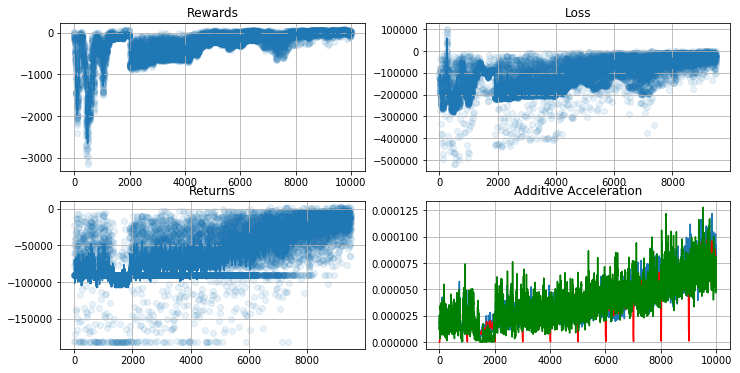

In [251]:
from itertools import count
#returns_history = []
#traj_batch = []
#rewards_history = []
#losses = []
gamma = 1.0
#successes = 0
alpha = 1.0 #10.0
betta = 10.0 #0.1
epsilon = 0.01
#additive_acceleration_history = []
#additive_acceleration_mean_history = []
#states = []
#max_state = -0.4
#improvements = 0

for i in range(NUM_EPISODES):
        
    # TO DO
    traj = []
    rewards = 0
    additive_acceleration = 0
    additive_acceleration_mean = 0
    mean_state = 0
    state = torch.FloatTensor(env.reset()).to(device)
    max_state_traj = state[0].item()
    for t in count():
        mu, sigma = policy(state)
        dist = Normal(mu, sigma)
        action = dist.sample().detach()
        next_state, reward, done, _ = env.step(action.numpy())
        #print(policy(state), action, state, reward)
        if next_state[0] > max_state_traj:
            max_state_traj = next_state[0]
        velocity = state[1].item()
        traj.append(transition(state, action, (100 if reward > 0 else -1)\
                              + alpha*(gamma * abs(next_state[1]) - abs(velocity))\
                              + betta*(max_state_traj - max_state if done else 0)\
                              #+ epsilon*(next_state[0]**2 if next_state[0] > 0 else 0)\
                   ))
        additive_acceleration += alpha*(gamma * abs(next_state[1]) - abs(velocity))
        mean_state += epsilon*(next_state[0]**2 if next_state[0] > 0 else 0)
        rewards += reward
        if not done:
            state = torch.FloatTensor(next_state).to(device)
        else:
            if next_state[0] >= env.goal_position:
                successes += 1
            break
    if max_state_traj > max_state:
        improvements += 1
        max_state = max_state_traj
    additive_acceleration_history.append(additive_acceleration/t)
    states.append(mean_state/t)
    if i > TRAIN_EVERY:
        additive_acceleration_mean = sum(additive_acceleration_history[-TRAIN_EVERY:])/len(additive_acceleration_history[-TRAIN_EVERY:])
    additive_acceleration_mean_history.append(additive_acceleration_mean)
    rewards_history.append(rewards)
    traj_batch.append(traj)
    
    #alpha *= DISCOUNT
    
    if i % TRAIN_EVERY:
        log_probs, returns = process_traj_batch(policy, traj_batch, DISCOUNT, division = False)
        returns = torch.FloatTensor(returns).to(device)
        returns_history.append(returns.sum().item())
        loss = (torch.sum(torch.mul(log_probs, returns).mul(-1), -1))
        #print(loss)
        #loss = -(log_probs * torch.FloatTensor(returns).to(device)).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        traj_batch = []
        print("successes = ", successes, ", improvements = ", improvements)
        
    if i % 10:
        clear_output(True)
        fig = plt.figure(figsize=[12, 6])
        ax1 = fig.add_subplot(2, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 3)
        ax4 = fig.add_subplot(2, 2, 4)
        ax1.set(title = 'Rewards'); ax1.grid()
        ax1.scatter(np.arange(len(rewards_history)), rewards_history, alpha=0.1)
        ax1.plot(moving_average(rewards_history, span=10, min_periods=10))
        ax2.set(title = 'Loss'); ax2.grid()
        ax2.scatter(np.arange(len(losses)), losses, alpha=0.1)
        ax2.plot(moving_average(losses, span=10, min_periods=10))
        ax3.set(title = 'Returns'); ax3.grid()
        ax3.scatter(np.arange(len(returns_history)), returns_history, alpha=0.1)
        ax3.plot(moving_average(returns_history, span=10, min_periods=10))
        ax4.set(title = 'Additive Acceleration'); ax4.grid()
        ax4.plot(moving_average(additive_acceleration_history, span=10, min_periods=10))
        ax4.plot(moving_average(additive_acceleration_mean_history, span=10, min_periods=10), color = 'red')
        ax4.plot(moving_average(states, span=10, min_periods=10), color = 'green')
        plt.show()

Протестируем обученного агента.

In [254]:
test_agent(env, DIST = Normal, agent=policy, n_episodes=500, render = False)

Episode 1 finished after 405 timesteps
Episode 2 finished after 498 timesteps
Episode 3 finished after 414 timesteps
Episode 4 finished after 403 timesteps
Episode 5 finished after 327 timesteps
Episode 6 finished after 132 timesteps
Episode 7 finished after 312 timesteps
Episode 8 finished after 302 timesteps
Episode 9 finished after 487 timesteps
Episode 10 finished after 640 timesteps
Episode 11 finished after 297 timesteps
Episode 12 finished after 555 timesteps
Episode 13 finished after 222 timesteps
Episode 14 finished after 392 timesteps
Episode 15 finished after 650 timesteps
Episode 16 finished after 353 timesteps
Episode 17 finished after 252 timesteps
Episode 18 finished after 230 timesteps
Episode 19 finished after 423 timesteps
Episode 20 finished after 397 timesteps
Episode 21 finished after 229 timesteps
Episode 22 finished after 294 timesteps
Episode 23 finished after 359 timesteps
Episode 24 finished after 237 timesteps
Episode 25 finished after 383 timesteps
Episode 2

8.995062577874355

In [256]:
test_agent(env, DIST = Normal, agent=policy, n_episodes=10, render = True)

Episode 1 finished after 610 timesteps
Episode 2 finished after 285 timesteps
Episode 3 finished after 305 timesteps
Episode 4 finished after 428 timesteps
Episode 5 finished after 285 timesteps
Episode 6 finished after 359 timesteps
Episode 7 finished after 361 timesteps
Episode 8 finished after 659 timesteps
Episode 9 finished after 481 timesteps
Episode 10 finished after 325 timesteps


-2.2526744919446697

In [257]:
torch.save(policy.state_dict(), "policy_REINFORCE_3.pth")

In [258]:
policy_frugal = Policy(STATE_SIZE, ACT_SIZE, HIDDEN_SIZE).to(device)
policy_frugal.load_state_dict(torch.load("policy_REINFORCE_3.pth"))
optimizer = Adam(policy_frugal.parameters(), lr = 1e-3)

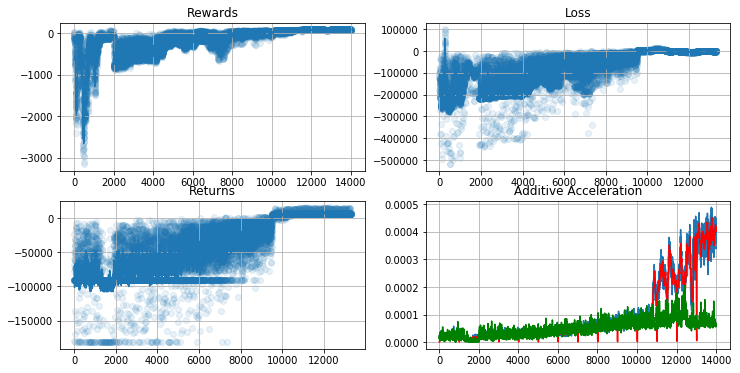

In [274]:
from itertools import count
#returns_history = []
#traj_batch = []
#rewards_history = []
#losses = []
gamma = 1.0
#successes = 0
alpha = 1.0 #10.0
betta = 10.0 #0.1
#additive_acceleration_history = []
#additive_acceleration_mean_history = []
#states = []
#max_state = -0.4
#improvements = 0

for i in range(NUM_EPISODES):
        
    # TO DO
    traj = []
    rewards = 0
    additive_acceleration = 0
    additive_acceleration_mean = 0
    mean_state = 0
    state = torch.FloatTensor(env.reset()).to(device)
    for t in count():
        mu, sigma = policy_frugal(state)
        dist = Normal(mu, sigma)
        action = dist.sample().detach()
        next_state, reward, done, _ = env.step(action.numpy())
        #print(policy(state), action, state, reward)
        if next_state[0] > max_state_traj:
            max_state_traj = next_state[0]
        velocity = state[1].item()
        traj.append(transition(state, action, reward))
        additive_acceleration += alpha*(gamma * abs(next_state[1]) - abs(velocity))
        mean_state += epsilon*(next_state[0]**2 if next_state[0] > 0 else 0)
        rewards += reward
        if not done:
            state = torch.FloatTensor(next_state).to(device)
        else:
            if next_state[0] >= env.goal_position:
                successes += 1
            break
    if max_state_traj > max_state:
        improvements += 1
        max_state = max_state_traj
    additive_acceleration_history.append(additive_acceleration/t)
    states.append(mean_state/t)
    if i > TRAIN_EVERY:
        additive_acceleration_mean = sum(additive_acceleration_history[-TRAIN_EVERY:])/len(additive_acceleration_history[-TRAIN_EVERY:])
    additive_acceleration_mean_history.append(additive_acceleration_mean)
    rewards_history.append(rewards)
    traj_batch.append(traj)
    
    #alpha *= DISCOUNT
    
    if i % TRAIN_EVERY:
        log_probs, returns = process_traj_batch(policy_frugal, traj_batch, DISCOUNT, division = False)
        returns = torch.FloatTensor(returns).to(device)
        returns_history.append(returns.sum().item())
        loss = (torch.sum(torch.mul(log_probs, returns).mul(-1), -1))
        #print(loss)
        #loss = -(log_probs * torch.FloatTensor(returns).to(device)).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        traj_batch = []
        print("successes = ", successes, ", improvements = ", improvements)
        
    if i % 10:
        clear_output(True)
        fig = plt.figure(figsize=[12, 6])
        ax1 = fig.add_subplot(2, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 3)
        ax4 = fig.add_subplot(2, 2, 4)
        ax1.set(title = 'Rewards'); ax1.grid()
        ax1.scatter(np.arange(len(rewards_history)), rewards_history, alpha=0.1)
        ax1.plot(moving_average(rewards_history, span=10, min_periods=10))
        ax2.set(title = 'Loss'); ax2.grid()
        ax2.scatter(np.arange(len(losses)), losses, alpha=0.1)
        ax2.plot(moving_average(losses, span=10, min_periods=10))
        ax3.set(title = 'Returns'); ax3.grid()
        ax3.scatter(np.arange(len(returns_history)), returns_history, alpha=0.1)
        ax3.plot(moving_average(returns_history, span=10, min_periods=10))
        ax4.set(title = 'Additive Acceleration'); ax4.grid()
        ax4.plot(moving_average(additive_acceleration_history, span=10, min_periods=10))
        ax4.plot(moving_average(additive_acceleration_mean_history, span=10, min_periods=10), color = 'red')
        ax4.plot(moving_average(states, span=10, min_periods=10), color = 'green')
        plt.show()

Episode 1 finished after 126 timesteps
Episode 2 finished after 129 timesteps
Episode 3 finished after 128 timesteps
Episode 4 finished after 208 timesteps
Episode 5 finished after 132 timesteps
Episode 6 finished after 116 timesteps
Episode 7 finished after 130 timesteps
Episode 8 finished after 120 timesteps
Episode 9 finished after 123 timesteps
Episode 10 finished after 128 timesteps
Episode 11 finished after 196 timesteps
Episode 12 finished after 125 timesteps
Episode 13 finished after 124 timesteps
Episode 14 finished after 210 timesteps
Episode 15 finished after 122 timesteps
Episode 16 finished after 131 timesteps
Episode 17 finished after 198 timesteps
Episode 18 finished after 127 timesteps
Episode 19 finished after 123 timesteps
Episode 20 finished after 282 timesteps
Episode 21 finished after 125 timesteps
Episode 22 finished after 204 timesteps
Episode 23 finished after 121 timesteps
Episode 24 finished after 129 timesteps
Episode 25 finished after 117 timesteps
Episode 2

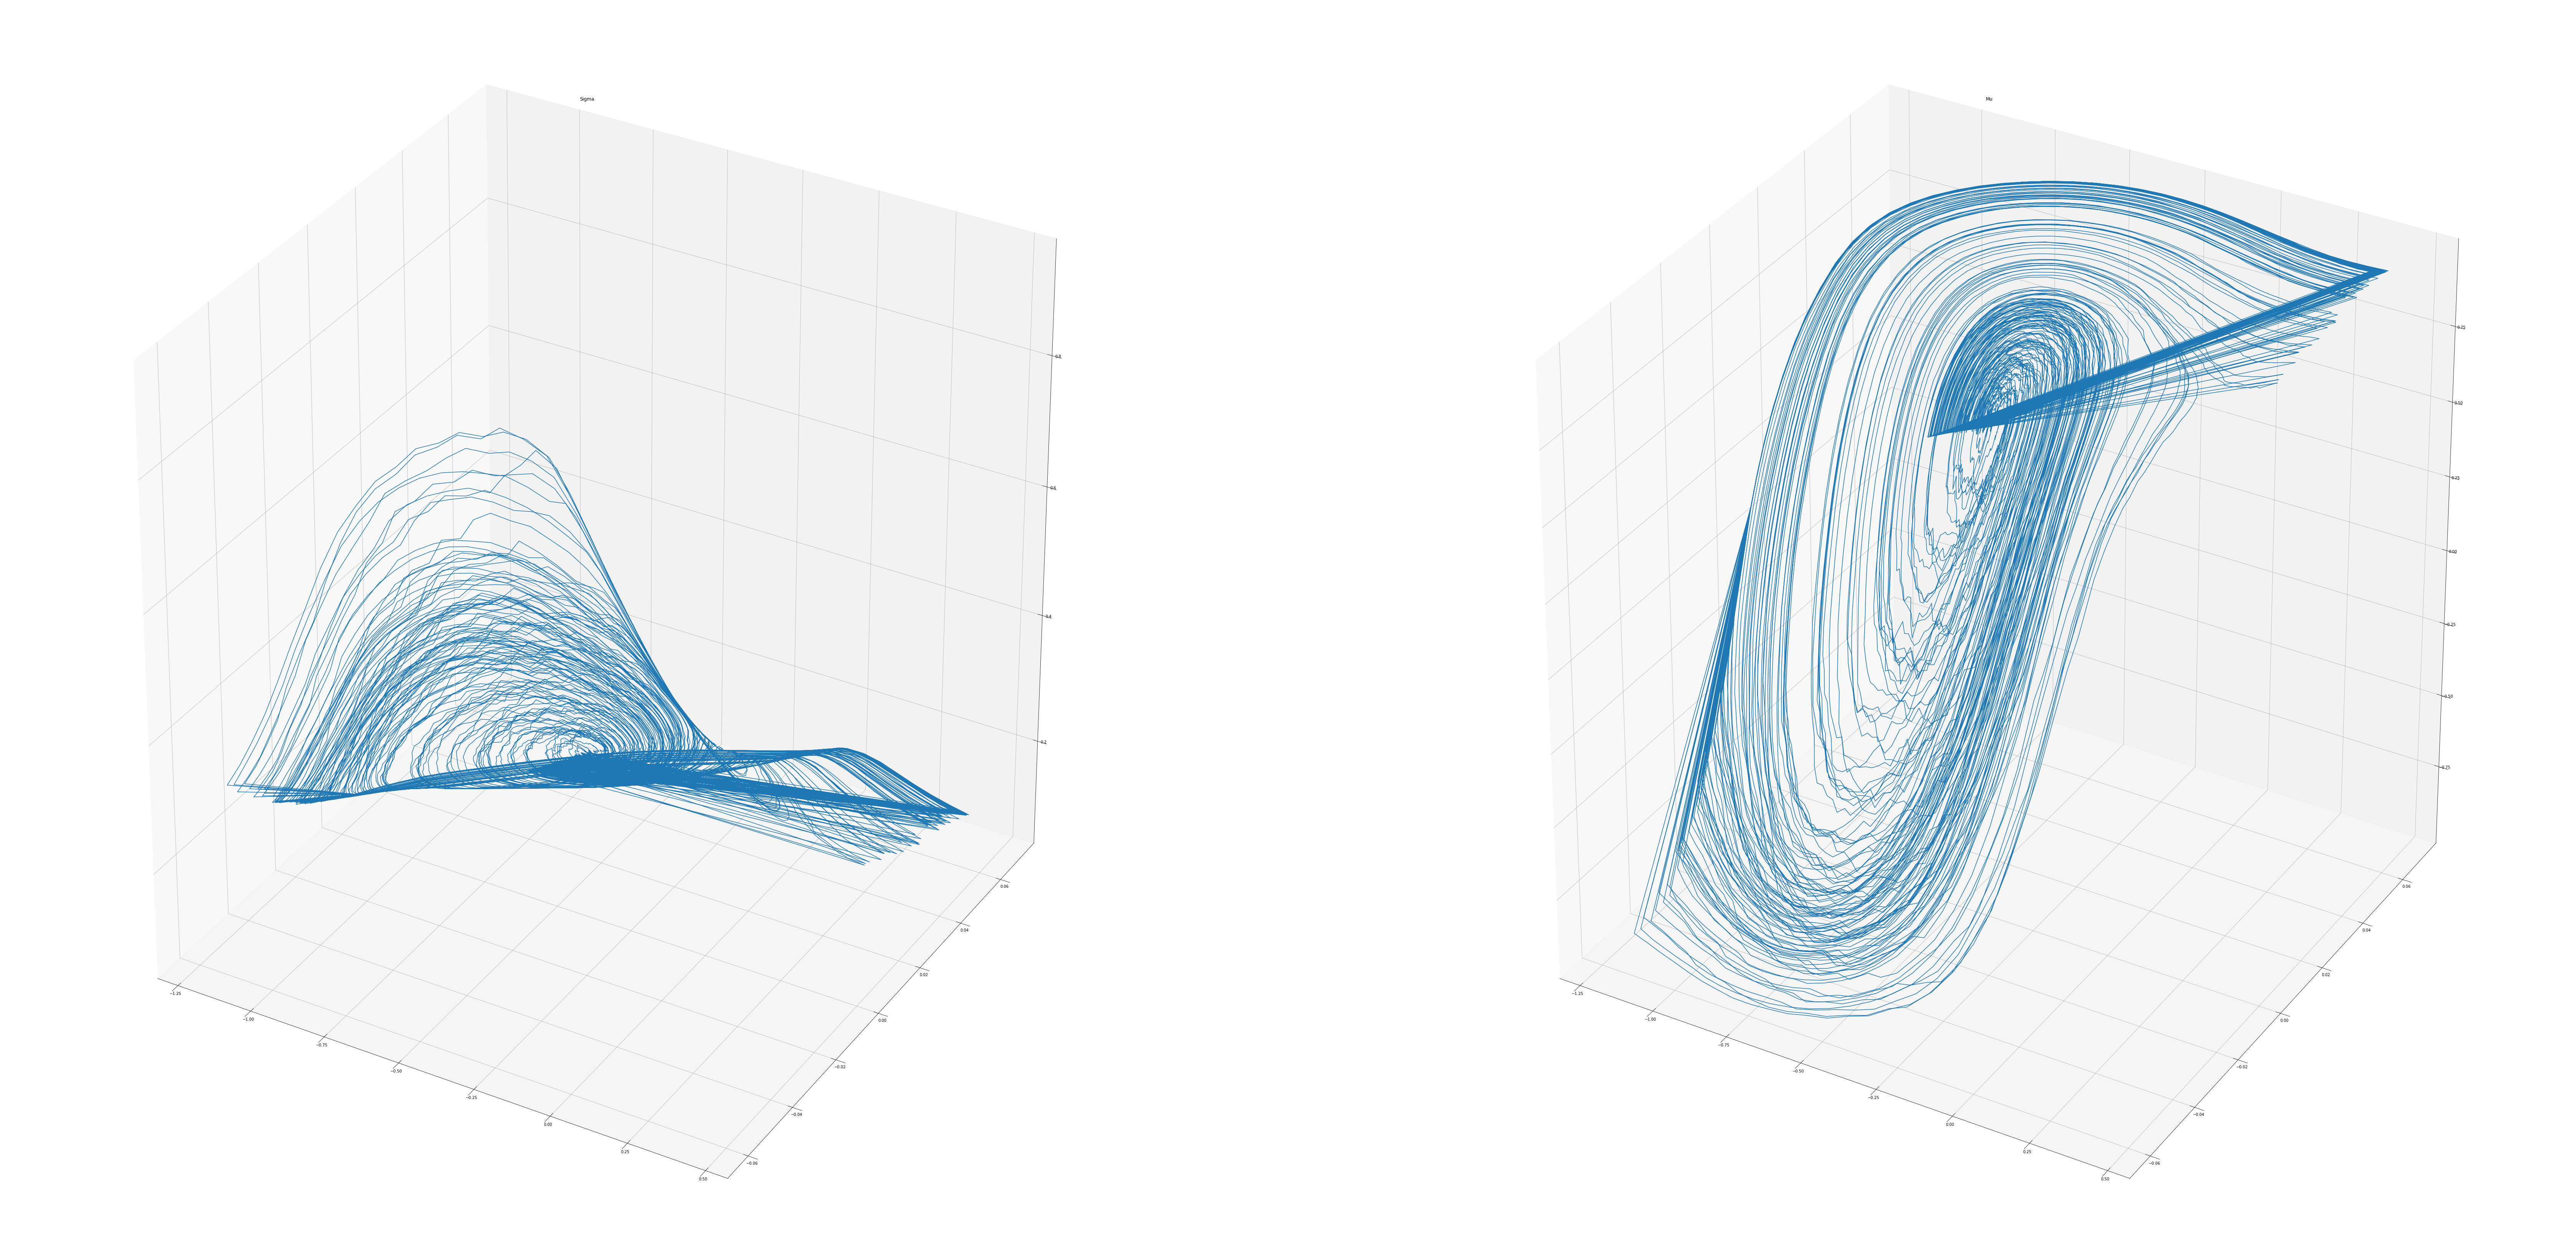

90.40598704497705

In [307]:
test_agent(env, DIST = Normal, agent=policy_frugal, n_episodes=100, render = False)

In [283]:
test_agent(env, DIST = Normal, agent=policy_frugal, n_episodes=10, render = True)

Episode 1 finished after 130 timesteps
Episode 2 finished after 126 timesteps
Episode 3 finished after 123 timesteps
Episode 4 finished after 119 timesteps
Episode 5 finished after 129 timesteps
Episode 6 finished after 121 timesteps
Episode 7 finished after 126 timesteps
Episode 8 finished after 195 timesteps
Episode 9 finished after 118 timesteps
Episode 10 finished after 117 timesteps


91.11891638206981

In [273]:
torch.save(policy_frugal.state_dict(), "policy_REINFORCE_frugal.pth")

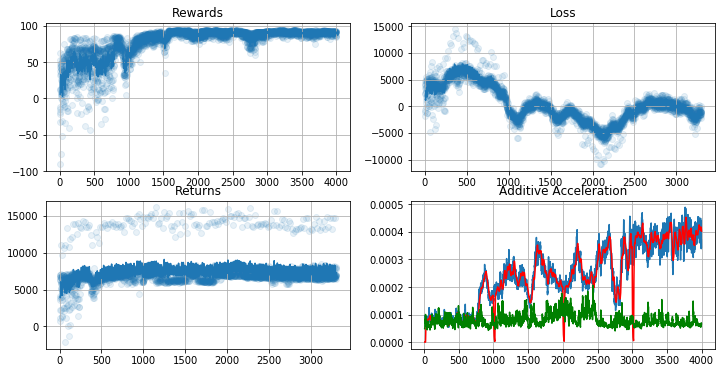

In [279]:
fig = plt.figure(figsize=[12, 6])
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
ax1.set(title = 'Rewards'); ax1.grid()
ax1.scatter(np.arange(len(rewards_history[10000:])), rewards_history[10000:], alpha=0.1)
ax1.plot(moving_average(rewards_history[10000:], span=10, min_periods=10))
ax2.set(title = 'Loss'); ax2.grid()
ax2.scatter(np.arange(len(losses[10000:])), losses[10000:], alpha=0.1)
ax2.plot(moving_average(losses[10000:], span=10, min_periods=10))
ax3.set(title = 'Returns'); ax3.grid()
ax3.scatter(np.arange(len(returns_history[10000:])), returns_history[10000:], alpha=0.1)
ax3.plot(moving_average(returns_history[10000:], span=10, min_periods=10))
ax4.set(title = 'Additive Acceleration'); ax4.grid()
ax4.plot(moving_average(additive_acceleration_history[10000:], span=10, min_periods=10))
ax4.plot(moving_average(additive_acceleration_mean_history[10000:], span=10, min_periods=10), color = 'red')
ax4.plot(moving_average(states[10000:], span=10, min_periods=10), color = 'green')
plt.show()

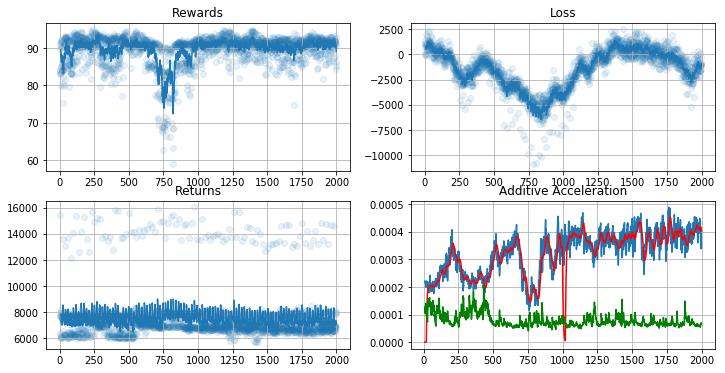

In [281]:
fig = plt.figure(figsize=[12, 6])
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
ax1.set(title = 'Rewards'); ax1.grid()
ax1.scatter(np.arange(len(rewards_history[-2000:])), rewards_history[-2000:], alpha=0.1)
ax1.plot(moving_average(rewards_history[-2000:], span=10, min_periods=10))
ax2.set(title = 'Loss'); ax2.grid()
ax2.scatter(np.arange(len(losses[-2000:])), losses[-2000:], alpha=0.1)
ax2.plot(moving_average(losses[-2000:], span=10, min_periods=10))
ax3.set(title = 'Returns'); ax3.grid()
ax3.scatter(np.arange(len(returns_history[-2000:])), returns_history[-2000:], alpha=0.1)
ax3.plot(moving_average(returns_history[-2000:], span=10, min_periods=10))
ax4.set(title = 'Additive Acceleration'); ax4.grid()
ax4.plot(moving_average(additive_acceleration_history[-2000:], span=10, min_periods=10))
ax4.plot(moving_average(additive_acceleration_mean_history[-2000:], span=10, min_periods=10), color = 'red')
ax4.plot(moving_average(states[-2000:], span=10, min_periods=10), color = 'green')
plt.show()

Обученный агент должен приближаться к искомому значению средней награды за 100 эпизодов больше 90.